In [1]:
%pip install -r requirements.txt
%pip install -e .

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 4.3 MB/s eta 0:00:00m eta 0:00:010:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 KB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/adachi/Documents/Data_pre
ERROR: file:///home/adachi/Documents/Data_pre does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [ ]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

## Settings

In [ ]:

n_tracks = 5
n_pitches = 72
lowest_pitch = 24
n_samples_per_song = 8
n_measures = 4
beat_resolution = 4
programs = [0, 0, 25, 33, 48]
is_drums = [True, False, False, False, False]
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']
tempo = 100

# Training
batch_size = 16
latent_dim = 128
n_steps = 20000

# Sampling
sample_interval = 100

In [ ]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)

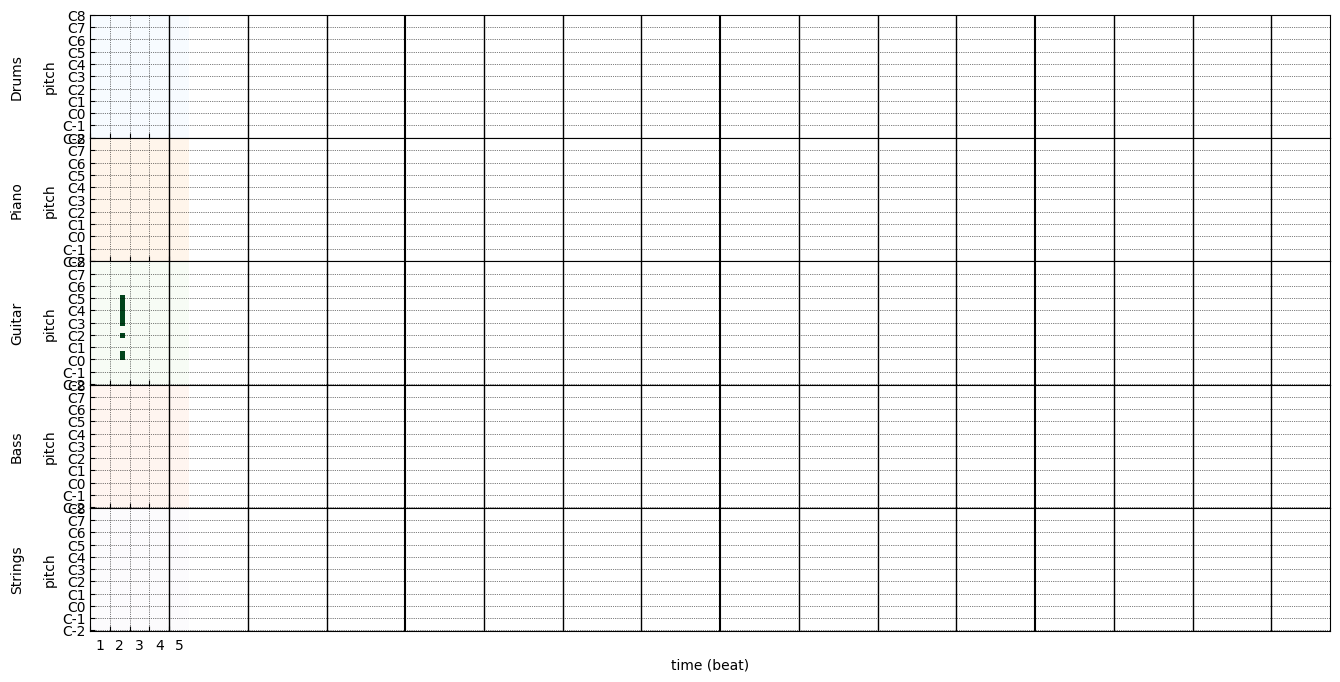

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pypianoroll import Track, Multitrack


tracks = []


concat_data = np.concatenate(X[:4], axis=0)


for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):


    instrument_pianoroll = concat_data[:, :, idx]


    if instrument_pianoroll.shape[1] < 128:
        pianoroll = np.pad(
            instrument_pianoroll,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
        )
    else:
        pianoroll = instrument_pianoroll

    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))

multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()

plt.gcf().set_size_inches((16, 8))

for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)

plt.show()

### Create dataset and data loader

In [ ]:
data = torch.as_tensor(X, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)


print(f"Nombre total d'échantillons dans X (len(X)) : {len(X)}")
print(f"Taille de batch (batch_size) : {batch_size}")


data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    drop_last=False,
    shuffle=True
)

print(f"Nombre de lots (batches) dans le DataLoader : {len(data_loader)}")

Nombre total d'échantillons dans X (len(X)) : 144
Taille de batch (batch_size) : 64
Nombre de lots (batches) dans le DataLoader : 3


In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):

    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()

    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()

    current_batch_size = real_samples.size(0)

# 2. Créer des vecteurs latents avec la bonne taille de lot (ici, 5)
    latent_vec = torch.randn(current_batch_size, latent_dim).to(device)
    fake_samples = generator(latent_vec)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()

    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Training Preparation

In [ ]:
import torch

# Définir l'appareil sur GPU si disponible, sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil : {device}")

Utilisation de l'appareil : cuda


In [ ]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to sotre history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Number of parameters in G: 313951
Number of parameters in D: 204321


/usr/local/lib/python3.12/dist-packages/livelossplot/outputs/matplotlib_plot.py:110: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()

(d_loss=-4.858996, g_loss= 0.616155): 100%|██████████████████▉| 19900/20000 [06:00<00:14,  6.67it/s]

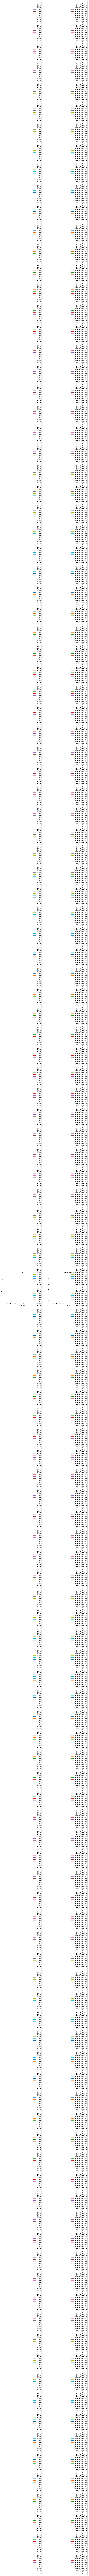

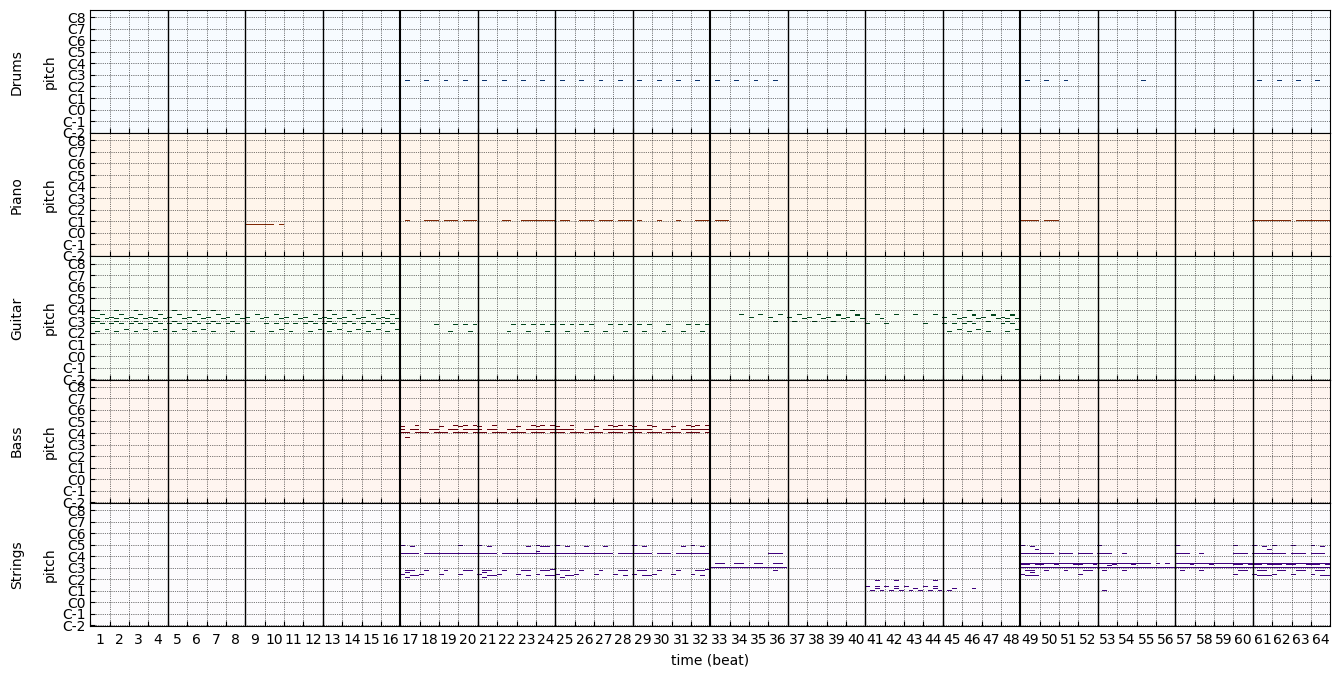


(d_loss=-5.971794, g_loss= 0.250124): 100%|██████████████████▉| 19901/20000 [06:09<02:08,  1.29s/it]

💾 Checkpoint sauvegardé à l'étape 19900



(d_loss=-5.840395, g_loss=-2.098312): 100%|██████████████████▉| 19951/20000 [06:16<00:12,  3.94it/s]

💾 Checkpoint sauvegardé à l'étape 19950



(d_loss=-5.581161, g_loss=-1.203416): 100%|███████████████████| 20000/20000 [06:23<00:00,  3.78it/s]

Entraînement terminé !


In [ ]:

save_path = "/content/models_checkpoints"
os.makedirs(save_path, exist_ok=True)
checkpoint_file = os.path.join(save_path, "musegan_checkpoint.pth")


if os.path.exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    step = checkpoint['step']
    print(f"🔄 Reprise de l'entraînement depuis le step {step}")
else:
    step = 0
    print("🚀 Aucun checkpoint trouvé, démarrage d'un nouvel entraînement")

running_d_loss = None
running_g_loss = None
loss_history = {'negative_critic_loss': [], 'g_loss': []} # Dictionnaire pour stocker les pertes CPU
progress_bar = tqdm(total=n_steps, initial=step, ncols=100, mininterval=1)

while step < n_steps:
    for real_samples_batch in data_loader:

        # 1. Déplacer les données sur le GPU
        real_samples = real_samples_batch[0].to(device)
        generator.train()

        # 2. Exécuter une étape d'entraînement
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples)

        # 3. CONVERTIR IMMÉDIATEMENT les pertes en nombres CPU avec .item()
        d_loss_cpu = d_loss.item()
        g_loss_cpu = g_loss.item()

        # 4. Mettre à jour les pertes lissées en utilisant SEULEMENT des nombres CPU
        if running_d_loss is None:
            running_d_loss = d_loss_cpu
            running_g_loss = g_loss_cpu
        else:
            running_d_loss = 0.05 * d_loss_cpu + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss_cpu + 0.95 * running_g_loss

        # 5. Stocker l'historique des pertes (valeurs CPU)
        loss_history['negative_critic_loss'].append(-running_d_loss)
        loss_history['g_loss'].append(running_g_loss)

        # 6. Mettre à jour la barre de progression (valeurs CPU)
        progress_bar.set_description_str(f"(d_loss={d_loss_cpu: 8.6f}, g_loss={g_loss_cpu: 8.6f})")

        # --- Affichage et Sauvegarde Périodiques ---
        if step % sample_interval == 0:
            generator.eval()

            # Convertir les échantillons générés en numpy (via le CPU)
            samples = generator(sample_latent).cpu().detach().numpy()
            history_samples[step] = samples

            clear_output(True)
            if step > 0:
                # CORRECTION FINALE : Recréer l'objet liveloss à chaque fois
                liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])
                liveloss.update(loss_history)
                liveloss.send()

            # --- Votre code pour afficher la musique ---
            samples_reshaped = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
                pianoroll = np.pad(samples_reshaped[idx] > 0.5, ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
                tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
            m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(measure_resolution, 4 * measure_resolution * n_measures, measure_resolution):
                    if x % (measure_resolution * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()
        if step % 50 == 0 and step > 0:
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'step': step
            }, checkpoint_file)
            print(f"💾 Checkpoint sauvegardé à l'étape {step}")

        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

# Nettoyer la barre de progression à la fin
progress_bar.close()
print("Entraînement terminé !")

## Training History

In [ ]:
# Show history
steps = [0, sample_interval, 10 * sample_interval, 100 * sample_interval, n_steps]
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
        )
        tracks.append(
            Track(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    axs = m.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 8))
    plt.show()